Epoch 1, Loss: 0.9927
Epoch 2, Loss: 0.9250
Epoch 3, Loss: 0.9778
Epoch 4, Loss: 0.4218
Epoch 5, Loss: 1.4883
Epoch 6, Loss: 0.5937
Epoch 7, Loss: 0.4115
Epoch 8, Loss: 0.1816
Test Accuracy: 74.46%


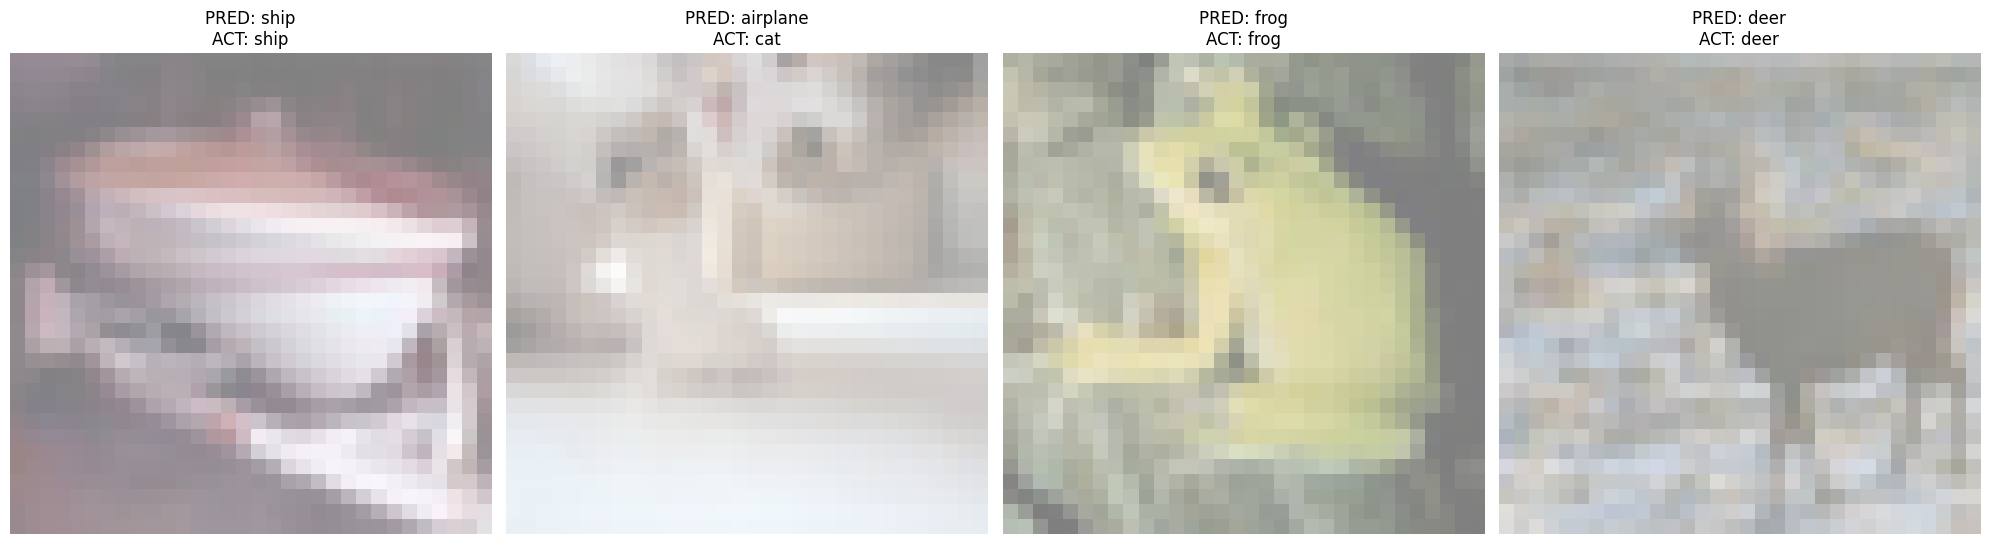

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import numpy as np

class ComplexCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)  # Output size now (256, 2, 2)
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)  # Output size now (256, 2, 2)
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.global_pool(x)
        x = self.classifier(x)
        return x

transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ComplexCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4) # CHANGED


# Training loop
for epoch in range(8):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

correct = 0
total = 0
model.eval()  # Turn off dropout, batchnorm, etc.

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Get class names
classes = train_data.classes

# Get some test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Move to device
images = images.to(device)
labels = labels.to(device)

# Get model predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Function to unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize (undo normalization)
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Show 8 images
fig = plt.figure(figsize=(20, 14))
for idx in range(4):
    ax = fig.add_subplot(1, 4, idx+1)
    imshow(images[idx])
    pred_label = classes[predicted[idx]]
    true_label = classes[labels[idx]]
    ax.set_title(f"PRED: {pred_label}\nACT: {true_label}", fontsize=12)
plt.tight_layout()
plt.show()
